In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_1_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:39 - loss: 0.2867 - STD: 1.5033e-04 - MAE: 0.5233

 4/64 [>.............................] - ETA: 1s - loss: 0.1105 - STD: 3.5585e-04 - MAE: 0.2672  

 5/64 [=>............................] - ETA: 2s - loss: 0.0924 - STD: 3.1548e-04 - MAE: 0.2319

 6/64 [=>............................] - ETA: 2s - loss: 0.0819 - STD: 2.7592e-04 - MAE: 0.2144

 7/64 [==>...........................] - ETA: 2s - loss: 0.0752 - STD: 2.4233e-04 - MAE: 0.2048

 8/64 [==>...........................] - ETA: 2s - loss: 0.0704 - STD: 2.1470e-04 - MAE: 0.1989

 9/64 [===>..........................] - ETA: 2s - loss: 0.0671 - STD: 1.9237e-04 - MAE: 0.1952

10/64 [===>..........................] - ETA: 2s - loss: 0.0644 - STD: 1.7448e-04 - MAE: 0.1923

11/64 [====>.........................] - ETA: 2s - loss: 0.0623 - STD: 1.6007e-04 - MAE: 0.1900

12/64 [====>.........................] - ETA: 2s - loss: 0.0603 - STD: 1.4829e-04 - MAE: 0.1878

13/64 [=====>........................] - ETA: 2s - loss: 0.0587 - STD: 1.3849e-04 - MAE: 0.1857

14/64 [=====>........................] - ETA: 2s - loss: 0.0570 - STD: 1.3025e-04 - MAE: 0.1833

15/64 [======>.......................] - ETA: 2s - loss: 0.0555 - STD: 1.2327e-04 - MAE: 0.1807

16/64 [======>.......................] - ETA: 2s - loss: 0.0539 - STD: 1.1729e-04 - MAE: 0.1777

17/64 [======>.......................] - ETA: 2s - loss: 0.0523 - STD: 1.1214e-04 - MAE: 0.1743

18/64 [=======>......................] - ETA: 2s - loss: 0.0507 - STD: 1.0765e-04 - MAE: 0.1705

19/64 [=======>......................] - ETA: 2s - loss: 0.0491 - STD: 1.0369e-04 - MAE: 0.1663

20/64 [========>.....................] - ETA: 2s - loss: 0.0475 - STD: 1.0013e-04 - MAE: 0.1616

21/64 [========>.....................] - ETA: 2s - loss: 0.0459 - STD: 9.6894e-05 - MAE: 0.1569

22/64 [=========>....................] - ETA: 2s - loss: 0.0444 - STD: 9.3934e-05 - MAE: 0.1526

23/64 [=========>....................] - ETA: 2s - loss: 0.0431 - STD: 9.1192e-05 - MAE: 0.1492

24/64 [==========>...................] - ETA: 2s - loss: 0.0418 - STD: 8.8622e-05 - MAE: 0.1467

25/64 [==========>...................] - ETA: 2s - loss: 0.0408 - STD: 8.6207e-05 - MAE: 0.1449

26/64 [===========>..................] - ETA: 2s - loss: 0.0398 - STD: 8.3910e-05 - MAE: 0.1436

27/64 [===========>..................] - ETA: 2s - loss: 0.0390 - STD: 8.1719e-05 - MAE: 0.1426

28/64 [============>.................] - ETA: 2s - loss: 0.0383 - STD: 7.9615e-05 - MAE: 0.1417

29/64 [============>.................] - ETA: 2s - loss: 0.0375 - STD: 7.7573e-05 - MAE: 0.1408

30/64 [=============>................] - ETA: 2s - loss: 0.0368 - STD: 7.5597e-05 - MAE: 0.1398

31/64 [=============>................] - ETA: 2s - loss: 0.0361 - STD: 7.3680e-05 - MAE: 0.1385

32/64 [==============>...............] - ETA: 1s - loss: 0.0354 - STD: 7.1828e-05 - MAE: 0.1370

33/64 [==============>...............] - ETA: 1s - loss: 0.0347 - STD: 7.0045e-05 - MAE: 0.1353

34/64 [==============>...............] - ETA: 1s - loss: 0.0340 - STD: 6.8327e-05 - MAE: 0.1334

35/64 [===============>..............] - ETA: 1s - loss: 0.0334 - STD: 6.6679e-05 - MAE: 0.1315

36/64 [===============>..............] - ETA: 1s - loss: 0.0329 - STD: 6.5100e-05 - MAE: 0.1296

37/64 [================>.............] - ETA: 1s - loss: 0.0324 - STD: 6.3591e-05 - MAE: 0.1277

38/64 [================>.............] - ETA: 1s - loss: 0.0318 - STD: 6.2151e-05 - MAE: 0.1259

39/64 [=================>............] - ETA: 1s - loss: 0.0314 - STD: 6.0779e-05 - MAE: 0.1242

40/64 [=================>............] - ETA: 1s - loss: 0.0310 - STD: 5.9473e-05 - MAE: 0.1226

41/64 [==================>...........] - ETA: 1s - loss: 0.0306 - STD: 5.8227e-05 - MAE: 0.1211

42/64 [==================>...........] - ETA: 1s - loss: 0.0302 - STD: 5.7038e-05 - MAE: 0.1196

43/64 [===================>..........] - ETA: 1s - loss: 0.0298 - STD: 5.5907e-05 - MAE: 0.1183

44/64 [===================>..........] - ETA: 1s - loss: 0.0294 - STD: 5.4828e-05 - MAE: 0.1170

45/64 [====================>.........] - ETA: 1s - loss: 0.0290 - STD: 5.3799e-05 - MAE: 0.1157

46/64 [====================>.........] - ETA: 1s - loss: 0.0287 - STD: 5.2818e-05 - MAE: 0.1146

47/64 [=====================>........] - ETA: 1s - loss: 0.0284 - STD: 5.1880e-05 - MAE: 0.1136

48/64 [=====================>........] - ETA: 1s - loss: 0.0281 - STD: 5.0985e-05 - MAE: 0.1127

49/64 [=====================>........] - ETA: 0s - loss: 0.0277 - STD: 5.0127e-05 - MAE: 0.1120

50/64 [======================>.......] - ETA: 0s - loss: 0.0274 - STD: 4.9306e-05 - MAE: 0.1113

51/64 [======================>.......] - ETA: 0s - loss: 0.0272 - STD: 4.8519e-05 - MAE: 0.1107

52/64 [=======================>......] - ETA: 0s - loss: 0.0269 - STD: 4.7762e-05 - MAE: 0.1101

53/64 [=======================>......] - ETA: 0s - loss: 0.0266 - STD: 4.7034e-05 - MAE: 0.1096

54/64 [========================>.....] - ETA: 0s - loss: 0.0264 - STD: 4.6334e-05 - MAE: 0.1091

55/64 [========================>.....] - ETA: 0s - loss: 0.0261 - STD: 4.5658e-05 - MAE: 0.1086

56/64 [=========================>....] - ETA: 0s - loss: 0.0259 - STD: 4.5007e-05 - MAE: 0.1080

57/64 [=========================>....] - ETA: 0s - loss: 0.0257 - STD: 4.4377e-05 - MAE: 0.1075

58/64 [==========================>...] - ETA: 0s - loss: 0.0254 - STD: 4.3769e-05 - MAE: 0.1069

59/64 [==========================>...] - ETA: 0s - loss: 0.0252 - STD: 4.3182e-05 - MAE: 0.1063

60/64 [===========================>..] - ETA: 0s - loss: 0.0250 - STD: 4.2614e-05 - MAE: 0.1057

61/64 [===========================>..] - ETA: 0s - loss: 0.0248 - STD: 4.2063e-05 - MAE: 0.1051

62/64 [============================>.] - ETA: 0s - loss: 0.0246 - STD: 4.1531e-05 - MAE: 0.1044

63/64 [============================>.] - ETA: 0s - loss: 0.0246 - STD: 4.1013e-05 - MAE: 0.1037

64/64 [==============================] - 7s 83ms/step - loss: 0.0244 - STD: 4.0515e-05 - MAE: 0.1031 - val_loss: 0.0172 - val_STD: 6.7237e-06 - val_MAE: 0.0733


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0133 - STD: 9.2021e-06 - MAE: 0.0649

 2/64 [..............................] - ETA: 4s - loss: 0.0129 - STD: 9.2364e-06 - MAE: 0.0642

 3/64 [>.............................] - ETA: 4s - loss: 0.0129 - STD: 9.2775e-06 - MAE: 0.0647

 4/64 [>.............................] - ETA: 4s - loss: 0.0129 - STD: 9.3280e-06 - MAE: 0.0650

 5/64 [=>............................] - ETA: 3s - loss: 0.0129 - STD: 9.3703e-06 - MAE: 0.0653

 6/64 [=>............................] - ETA: 3s - loss: 0.0129 - STD: 9.4319e-06 - MAE: 0.0657

 7/64 [==>...........................] - ETA: 3s - loss: 0.0128 - STD: 9.4897e-06 - MAE: 0.0660

 8/64 [==>...........................] - ETA: 3s - loss: 0.0128 - STD: 9.5507e-06 - MAE: 0.0666

 9/64 [===>..........................] - ETA: 3s - loss: 0.0128 - STD: 9.6143e-06 - MAE: 0.0672

10/64 [===>..........................] - ETA: 3s - loss: 0.0128 - STD: 9.6819e-06 - MAE: 0.0678

11/64 [====>.........................] - ETA: 3s - loss: 0.0128 - STD: 9.7431e-06 - MAE: 0.0683

12/64 [====>.........................] - ETA: 3s - loss: 0.0128 - STD: 9.8064e-06 - MAE: 0.0688

13/64 [=====>........................] - ETA: 3s - loss: 0.0128 - STD: 9.8668e-06 - MAE: 0.0692

14/64 [=====>........................] - ETA: 3s - loss: 0.0128 - STD: 9.9277e-06 - MAE: 0.0695

15/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 9.9824e-06 - MAE: 0.0696

16/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 1.0033e-05 - MAE: 0.0698

17/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 1.0078e-05 - MAE: 0.0699

18/64 [=======>......................] - ETA: 3s - loss: 0.0127 - STD: 1.0123e-05 - MAE: 0.0700

19/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 1.0170e-05 - MAE: 0.0699

20/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 1.0214e-05 - MAE: 0.0699

21/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 1.0262e-05 - MAE: 0.0699

22/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 1.0304e-05 - MAE: 0.0698

23/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 1.0353e-05 - MAE: 0.0697

24/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 1.0404e-05 - MAE: 0.0697

25/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 1.0456e-05 - MAE: 0.0696

26/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 1.0509e-05 - MAE: 0.0695

27/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 1.0560e-05 - MAE: 0.0695

28/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 1.0619e-05 - MAE: 0.0696

29/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 1.0678e-05 - MAE: 0.0696

30/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 1.0737e-05 - MAE: 0.0697

31/64 [=============>................] - ETA: 2s - loss: 0.0128 - STD: 1.0800e-05 - MAE: 0.0698

32/64 [==============>...............] - ETA: 2s - loss: 0.0127 - STD: 1.0861e-05 - MAE: 0.0698

33/64 [==============>...............] - ETA: 2s - loss: 0.0127 - STD: 1.0922e-05 - MAE: 0.0699

34/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 1.0985e-05 - MAE: 0.0699

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 1.1048e-05 - MAE: 0.0699

36/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 1.1114e-05 - MAE: 0.0700

37/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 1.1180e-05 - MAE: 0.0700

38/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 1.1246e-05 - MAE: 0.0700

39/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 1.1312e-05 - MAE: 0.0700

40/64 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 1.1378e-05 - MAE: 0.0700

41/64 [==================>...........] - ETA: 1s - loss: 0.0128 - STD: 1.1444e-05 - MAE: 0.0700

42/64 [==================>...........] - ETA: 1s - loss: 0.0128 - STD: 1.1515e-05 - MAE: 0.0700

43/64 [===================>..........] - ETA: 1s - loss: 0.0128 - STD: 1.1587e-05 - MAE: 0.0700

44/64 [===================>..........] - ETA: 1s - loss: 0.0128 - STD: 1.1657e-05 - MAE: 0.0700

45/64 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 1.1727e-05 - MAE: 0.0700

46/64 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 1.1800e-05 - MAE: 0.0699

47/64 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 1.1874e-05 - MAE: 0.0699

48/64 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 1.1951e-05 - MAE: 0.0699

49/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 1.2030e-05 - MAE: 0.0699

50/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 1.2106e-05 - MAE: 0.0699

51/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 1.2185e-05 - MAE: 0.0699

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 1.2265e-05 - MAE: 0.0699

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 1.2345e-05 - MAE: 0.0700

54/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 1.2431e-05 - MAE: 0.0700

55/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 1.2515e-05 - MAE: 0.0700

56/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 1.2602e-05 - MAE: 0.0700

57/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 1.2693e-05 - MAE: 0.0700

58/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 1.2781e-05 - MAE: 0.0699

59/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 1.2869e-05 - MAE: 0.0699

61/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 1.3053e-05 - MAE: 0.0699

62/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 1.3149e-05 - MAE: 0.0699

63/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 1.3247e-05 - MAE: 0.0700

64/64 [==============================] - ETA: 0s - loss: 0.0127 - STD: 1.3345e-05 - MAE: 0.0700

64/64 [==============================] - 4s 69ms/step - loss: 0.0127 - STD: 1.3345e-05 - MAE: 0.0700 - val_loss: 0.0168 - val_STD: 1.4401e-05 - val_MAE: 0.0798


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0122 - STD: 1.9627e-05 - MAE: 0.0695

 2/64 [..............................] - ETA: 4s - loss: 0.0123 - STD: 1.9859e-05 - MAE: 0.0698

 3/64 [>.............................] - ETA: 4s - loss: 0.0123 - STD: 2.0055e-05 - MAE: 0.0698

 4/64 [>.............................] - ETA: 4s - loss: 0.0125 - STD: 2.0249e-05 - MAE: 0.0701

 5/64 [=>............................] - ETA: 4s - loss: 0.0125 - STD: 2.0433e-05 - MAE: 0.0702

 6/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 2.0591e-05 - MAE: 0.0702

 7/64 [==>...........................] - ETA: 3s - loss: 0.0127 - STD: 2.0772e-05 - MAE: 0.0703

 8/64 [==>...........................] - ETA: 3s - loss: 0.0126 - STD: 2.0930e-05 - MAE: 0.0702

 9/64 [===>..........................] - ETA: 3s - loss: 0.0126 - STD: 2.1089e-05 - MAE: 0.0700

10/64 [===>..........................] - ETA: 3s - loss: 0.0126 - STD: 2.1268e-05 - MAE: 0.0700

11/64 [====>.........................] - ETA: 3s - loss: 0.0126 - STD: 2.1461e-05 - MAE: 0.0699

12/64 [====>.........................] - ETA: 3s - loss: 0.0126 - STD: 2.1656e-05 - MAE: 0.0699

13/64 [=====>........................] - ETA: 3s - loss: 0.0126 - STD: 2.1837e-05 - MAE: 0.0699

14/64 [=====>........................] - ETA: 3s - loss: 0.0126 - STD: 2.2038e-05 - MAE: 0.0698

15/64 [======>.......................] - ETA: 3s - loss: 0.0126 - STD: 2.2239e-05 - MAE: 0.0698

16/64 [======>.......................] - ETA: 3s - loss: 0.0126 - STD: 2.2454e-05 - MAE: 0.0698

17/64 [======>.......................] - ETA: 3s - loss: 0.0126 - STD: 2.2673e-05 - MAE: 0.0698

18/64 [=======>......................] - ETA: 3s - loss: 0.0126 - STD: 2.2890e-05 - MAE: 0.0698

19/64 [=======>......................] - ETA: 3s - loss: 0.0126 - STD: 2.3119e-05 - MAE: 0.0699

20/64 [========>.....................] - ETA: 2s - loss: 0.0126 - STD: 2.3351e-05 - MAE: 0.0699

21/64 [========>.....................] - ETA: 2s - loss: 0.0126 - STD: 2.3593e-05 - MAE: 0.0699

22/64 [=========>....................] - ETA: 2s - loss: 0.0126 - STD: 2.3836e-05 - MAE: 0.0699

23/64 [=========>....................] - ETA: 2s - loss: 0.0126 - STD: 2.4080e-05 - MAE: 0.0699

24/64 [==========>...................] - ETA: 2s - loss: 0.0126 - STD: 2.4338e-05 - MAE: 0.0700

25/64 [==========>...................] - ETA: 2s - loss: 0.0126 - STD: 2.4602e-05 - MAE: 0.0700

26/64 [===========>..................] - ETA: 2s - loss: 0.0126 - STD: 2.4875e-05 - MAE: 0.0700

27/64 [===========>..................] - ETA: 2s - loss: 0.0126 - STD: 2.5146e-05 - MAE: 0.0700

28/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 2.5430e-05 - MAE: 0.0701

30/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 2.5997e-05 - MAE: 0.0700

31/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 2.6295e-05 - MAE: 0.0701

32/64 [==============>...............] - ETA: 2s - loss: 0.0127 - STD: 2.6602e-05 - MAE: 0.0701

33/64 [==============>...............] - ETA: 2s - loss: 0.0127 - STD: 2.6909e-05 - MAE: 0.0700

34/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.7228e-05 - MAE: 0.0700

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.7548e-05 - MAE: 0.0700

36/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.7888e-05 - MAE: 0.0700

37/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.8227e-05 - MAE: 0.0700

38/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.8576e-05 - MAE: 0.0700

39/64 [=================>............] - ETA: 1s - loss: 0.0126 - STD: 2.8940e-05 - MAE: 0.0699

40/64 [=================>............] - ETA: 1s - loss: 0.0126 - STD: 2.9303e-05 - MAE: 0.0699

41/64 [==================>...........] - ETA: 1s - loss: 0.0126 - STD: 2.9695e-05 - MAE: 0.0699

42/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 3.0086e-05 - MAE: 0.0699

43/64 [===================>..........] - ETA: 1s - loss: 0.0126 - STD: 3.0491e-05 - MAE: 0.0699

44/64 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 3.0910e-05 - MAE: 0.0699

45/64 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 3.1346e-05 - MAE: 0.0699

46/64 [====================>.........] - ETA: 1s - loss: 0.0126 - STD: 3.1789e-05 - MAE: 0.0699

47/64 [=====================>........] - ETA: 1s - loss: 0.0126 - STD: 3.2243e-05 - MAE: 0.0699

48/64 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 3.2720e-05 - MAE: 0.0700

49/64 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 3.3198e-05 - MAE: 0.0700

50/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 3.3696e-05 - MAE: 0.0700

51/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 3.4199e-05 - MAE: 0.0700

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 3.4713e-05 - MAE: 0.0700

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 3.5262e-05 - MAE: 0.0700

54/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 3.5821e-05 - MAE: 0.0701

55/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 3.6400e-05 - MAE: 0.0701

56/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 3.6985e-05 - MAE: 0.0701

57/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 3.7582e-05 - MAE: 0.0701

58/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 3.8213e-05 - MAE: 0.0701

59/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 3.8858e-05 - MAE: 0.0701

60/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 3.9510e-05 - MAE: 0.0701

61/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 4.0186e-05 - MAE: 0.0701

62/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 4.0878e-05 - MAE: 0.0701

63/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 4.1601e-05 - MAE: 0.0701

64/64 [==============================] - ETA: 0s - loss: 0.0127 - STD: 4.2336e-05 - MAE: 0.0701

64/64 [==============================] - 4s 68ms/step - loss: 0.0127 - STD: 4.2336e-05 - MAE: 0.0701 - val_loss: 0.0168 - val_STD: 6.6508e-05 - val_MAE: 0.0791


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0125 - STD: 9.2114e-05 - MAE: 0.0693

 2/64 [..............................] - ETA: 4s - loss: 0.0126 - STD: 9.3607e-05 - MAE: 0.0699

 3/64 [>.............................] - ETA: 3s - loss: 0.0125 - STD: 9.4863e-05 - MAE: 0.0698

 4/64 [>.............................] - ETA: 3s - loss: 0.0127 - STD: 9.6521e-05 - MAE: 0.0701

 5/64 [=>............................] - ETA: 3s - loss: 0.0127 - STD: 9.8231e-05 - MAE: 0.0701

 6/64 [=>............................] - ETA: 3s - loss: 0.0127 - STD: 1.0008e-04 - MAE: 0.0702

 7/64 [==>...........................] - ETA: 3s - loss: 0.0128 - STD: 1.0167e-04 - MAE: 0.0703

 8/64 [==>...........................] - ETA: 3s - loss: 0.0128 - STD: 1.0343e-04 - MAE: 0.0703

 9/64 [===>..........................] - ETA: 3s - loss: 0.0128 - STD: 1.0521e-04 - MAE: 0.0704

10/64 [===>..........................] - ETA: 3s - loss: 0.0128 - STD: 1.0697e-04 - MAE: 0.0704

11/64 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 1.0878e-04 - MAE: 0.0703

12/64 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 1.1064e-04 - MAE: 0.0703

13/64 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 1.1257e-04 - MAE: 0.0703

14/64 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 1.1452e-04 - MAE: 0.0702

15/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 1.1648e-04 - MAE: 0.0702

16/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 1.1852e-04 - MAE: 0.0702

17/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 1.2060e-04 - MAE: 0.0701

18/64 [=======>......................] - ETA: 3s - loss: 0.0127 - STD: 1.2268e-04 - MAE: 0.0702

19/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 1.2487e-04 - MAE: 0.0702

20/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 1.2712e-04 - MAE: 0.0701

21/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 1.2943e-04 - MAE: 0.0700

22/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 1.3192e-04 - MAE: 0.0700

23/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 1.3444e-04 - MAE: 0.0699

24/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 1.3707e-04 - MAE: 0.0699

25/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 1.3976e-04 - MAE: 0.0699

26/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 1.4257e-04 - MAE: 0.0699

27/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 1.4547e-04 - MAE: 0.0700

28/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 1.4851e-04 - MAE: 0.0700

29/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 1.5174e-04 - MAE: 0.0700

30/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 1.5509e-04 - MAE: 0.0700

31/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 1.5849e-04 - MAE: 0.0700

32/64 [==============>...............] - ETA: 2s - loss: 0.0127 - STD: 1.6201e-04 - MAE: 0.0700

33/64 [==============>...............] - ETA: 2s - loss: 0.0126 - STD: 1.6564e-04 - MAE: 0.0700

34/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 1.6950e-04 - MAE: 0.0700

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 1.7338e-04 - MAE: 0.0700

36/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 1.7740e-04 - MAE: 0.0700

37/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 1.8163e-04 - MAE: 0.0700

38/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 1.8602e-04 - MAE: 0.0700

39/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 1.9066e-04 - MAE: 0.0700

40/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 1.9546e-04 - MAE: 0.0700

41/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 2.0055e-04 - MAE: 0.0700

42/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 2.0585e-04 - MAE: 0.0700

43/64 [===================>..........] - ETA: 1s - loss: 0.0126 - STD: 2.1137e-04 - MAE: 0.0699

44/64 [===================>..........] - ETA: 1s - loss: 0.0126 - STD: 2.1718e-04 - MAE: 0.0699

45/64 [====================>.........] - ETA: 1s - loss: 0.0126 - STD: 2.2322e-04 - MAE: 0.0699

46/64 [====================>.........] - ETA: 1s - loss: 0.0126 - STD: 2.2952e-04 - MAE: 0.0700

47/64 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 2.3618e-04 - MAE: 0.0700

49/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.5033e-04 - MAE: 0.0700

50/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.5787e-04 - MAE: 0.0701

51/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.6583e-04 - MAE: 0.0701

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.7403e-04 - MAE: 0.0701

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.8261e-04 - MAE: 0.0701

54/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.9162e-04 - MAE: 0.0701

55/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 3.0103e-04 - MAE: 0.0701

56/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 3.1079e-04 - MAE: 0.0701

57/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 3.2119e-04 - MAE: 0.0701

58/64 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 3.3177e-04 - MAE: 0.0701

59/64 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 3.4307e-04 - MAE: 0.0700

60/64 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 3.5486e-04 - MAE: 0.0700

61/64 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 3.6752e-04 - MAE: 0.0700

62/64 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 3.8090e-04 - MAE: 0.0700

63/64 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 3.9502e-04 - MAE: 0.0700

64/64 [==============================] - ETA: 0s - loss: 0.0126 - STD: 4.1003e-04 - MAE: 0.0700

64/64 [==============================] - 4s 69ms/step - loss: 0.0126 - STD: 4.1003e-04 - MAE: 0.0700 - val_loss: 0.0165 - val_STD: 0.0010 - val_MAE: 0.0790


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0126 - STD: 0.0015 - MAE: 0.0705

 2/64 [..............................] - ETA: 4s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0704

 3/64 [>.............................] - ETA: 4s - loss: 0.0124 - STD: 0.0015 - MAE: 0.0702

 4/64 [>.............................] - ETA: 3s - loss: 0.0124 - STD: 0.0016 - MAE: 0.0702

 5/64 [=>............................] - ETA: 3s - loss: 0.0125 - STD: 0.0016 - MAE: 0.0703

 6/64 [=>............................] - ETA: 3s - loss: 0.0125 - STD: 0.0017 - MAE: 0.0701

 7/64 [==>...........................] - ETA: 3s - loss: 0.0125 - STD: 0.0017 - MAE: 0.0702

 9/64 [===>..........................] - ETA: 3s - loss: 0.0126 - STD: 0.0019 - MAE: 0.0703

10/64 [===>..........................] - ETA: 3s - loss: 0.0126 - STD: 0.0019 - MAE: 0.0703

11/64 [====>.........................] - ETA: 3s - loss: 0.0126 - STD: 0.0020 - MAE: 0.0703

12/64 [====>.........................] - ETA: 3s - loss: 0.0125 - STD: 0.0021 - MAE: 0.0703

13/64 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 0.0022 - MAE: 0.0702

14/64 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 0.0022 - MAE: 0.0702

15/64 [======>.......................] - ETA: 3s - loss: 0.0124 - STD: 0.0023 - MAE: 0.0700

16/64 [======>.......................] - ETA: 3s - loss: 0.0124 - STD: 0.0024 - MAE: 0.0699

17/64 [======>.......................] - ETA: 2s - loss: 0.0124 - STD: 0.0025 - MAE: 0.0698

18/64 [=======>......................] - ETA: 2s - loss: 0.0124 - STD: 0.0026 - MAE: 0.0697

19/64 [=======>......................] - ETA: 2s - loss: 0.0124 - STD: 0.0027 - MAE: 0.0696

20/64 [========>.....................] - ETA: 2s - loss: 0.0124 - STD: 0.0028 - MAE: 0.0695

21/64 [========>.....................] - ETA: 2s - loss: 0.0123 - STD: 0.0029 - MAE: 0.0694

22/64 [=========>....................] - ETA: 2s - loss: 0.0123 - STD: 0.0030 - MAE: 0.0692

23/64 [=========>....................] - ETA: 2s - loss: 0.0123 - STD: 0.0032 - MAE: 0.0692

24/64 [==========>...................] - ETA: 2s - loss: 0.0122 - STD: 0.0033 - MAE: 0.0691

25/64 [==========>...................] - ETA: 2s - loss: 0.0122 - STD: 0.0034 - MAE: 0.0690

26/64 [===========>..................] - ETA: 2s - loss: 0.0122 - STD: 0.0036 - MAE: 0.0690

27/64 [===========>..................] - ETA: 2s - loss: 0.0122 - STD: 0.0037 - MAE: 0.0690

28/64 [============>.................] - ETA: 2s - loss: 0.0122 - STD: 0.0039 - MAE: 0.0689

29/64 [============>.................] - ETA: 2s - loss: 0.0121 - STD: 0.0041 - MAE: 0.0688

30/64 [=============>................] - ETA: 2s - loss: 0.0121 - STD: 0.0043 - MAE: 0.0688

31/64 [=============>................] - ETA: 2s - loss: 0.0121 - STD: 0.0044 - MAE: 0.0687

32/64 [==============>...............] - ETA: 2s - loss: 0.0121 - STD: 0.0046 - MAE: 0.0686

33/64 [==============>...............] - ETA: 2s - loss: 0.0120 - STD: 0.0048 - MAE: 0.0685

34/64 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 0.0051 - MAE: 0.0684

35/64 [===============>..............] - ETA: 1s - loss: 0.0120 - STD: 0.0053 - MAE: 0.0682

36/64 [===============>..............] - ETA: 1s - loss: 0.0119 - STD: 0.0055 - MAE: 0.0681

37/64 [================>.............] - ETA: 1s - loss: 0.0119 - STD: 0.0058 - MAE: 0.0679

38/64 [================>.............] - ETA: 1s - loss: 0.0118 - STD: 0.0060 - MAE: 0.0678

39/64 [=================>............] - ETA: 1s - loss: 0.0118 - STD: 0.0063 - MAE: 0.0676

40/64 [=================>............] - ETA: 1s - loss: 0.0117 - STD: 0.0066 - MAE: 0.0675

41/64 [==================>...........] - ETA: 1s - loss: 0.0117 - STD: 0.0069 - MAE: 0.0674

42/64 [==================>...........] - ETA: 1s - loss: 0.0117 - STD: 0.0072 - MAE: 0.0672

43/64 [===================>..........] - ETA: 1s - loss: 0.0116 - STD: 0.0076 - MAE: 0.0671

44/64 [===================>..........] - ETA: 1s - loss: 0.0116 - STD: 0.0079 - MAE: 0.0669

45/64 [====================>.........] - ETA: 1s - loss: 0.0115 - STD: 0.0083 - MAE: 0.0668

46/64 [====================>.........] - ETA: 1s - loss: 0.0115 - STD: 0.0086 - MAE: 0.0666

47/64 [=====================>........] - ETA: 1s - loss: 0.0114 - STD: 0.0090 - MAE: 0.0665

48/64 [=====================>........] - ETA: 1s - loss: 0.0114 - STD: 0.0094 - MAE: 0.0663

49/64 [=====================>........] - ETA: 0s - loss: 0.0113 - STD: 0.0099 - MAE: 0.0661

50/64 [======================>.......] - ETA: 0s - loss: 0.0112 - STD: 0.0103 - MAE: 0.0659

51/64 [======================>.......] - ETA: 0s - loss: 0.0112 - STD: 0.0108 - MAE: 0.0657

52/64 [=======================>......] - ETA: 0s - loss: 0.0111 - STD: 0.0113 - MAE: 0.0654

53/64 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 0.0118 - MAE: 0.0652

54/64 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 0.0123 - MAE: 0.0650

55/64 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 0.0128 - MAE: 0.0648

56/64 [=========================>....] - ETA: 0s - loss: 0.0108 - STD: 0.0134 - MAE: 0.0645

57/64 [=========================>....] - ETA: 0s - loss: 0.0108 - STD: 0.0139 - MAE: 0.0643

58/64 [==========================>...] - ETA: 0s - loss: 0.0107 - STD: 0.0145 - MAE: 0.0640

59/64 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 0.0151 - MAE: 0.0638

60/64 [===========================>..] - ETA: 0s - loss: 0.0105 - STD: 0.0157 - MAE: 0.0635

61/64 [===========================>..] - ETA: 0s - loss: 0.0105 - STD: 0.0163 - MAE: 0.0633

62/64 [============================>.] - ETA: 0s - loss: 0.0104 - STD: 0.0170 - MAE: 0.0630

63/64 [============================>.] - ETA: 0s - loss: 0.0103 - STD: 0.0176 - MAE: 0.0628

64/64 [==============================] - ETA: 0s - loss: 0.0102 - STD: 0.0182 - MAE: 0.0625

64/64 [==============================] - 4s 69ms/step - loss: 0.0102 - STD: 0.0182 - MAE: 0.0625 - val_loss: 0.0075 - val_STD: 0.0440 - val_MAE: 0.0527


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0610 - MAE: 0.0448

 2/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0447

 4/64 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0646 - MAE: 0.0439

 5/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0650 - MAE: 0.0436

 6/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0435

 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0433

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0431

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0688 - MAE: 0.0429

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0427

11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0425

12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0423

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0421

14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0419

15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0417

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0415

17/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0413

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0411

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0410

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0409

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0407

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0405

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0779 - MAE: 0.0404

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0402

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0401

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0790 - MAE: 0.0400

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0796 - MAE: 0.0398

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0801 - MAE: 0.0397

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0804 - MAE: 0.0395

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0394

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0811 - MAE: 0.0393

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0816 - MAE: 0.0392

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0819 - MAE: 0.0391

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0389

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0824 - MAE: 0.0388

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0828 - MAE: 0.0387

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0386

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0832 - MAE: 0.0385

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0385

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0839 - MAE: 0.0384

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0842 - MAE: 0.0383

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0844 - MAE: 0.0382

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0847 - MAE: 0.0381

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0850 - MAE: 0.0380

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0852 - MAE: 0.0379

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0854 - MAE: 0.0378

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0856 - MAE: 0.0377

48/64 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0858 - MAE: 0.0376

49/64 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0860 - MAE: 0.0375

50/64 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0861 - MAE: 0.0375

51/64 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0864 - MAE: 0.0374

52/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0866 - MAE: 0.0373

53/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0868 - MAE: 0.0373

54/64 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0870 - MAE: 0.0372

55/64 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0872 - MAE: 0.0371

56/64 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0873 - MAE: 0.0370

57/64 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0875 - MAE: 0.0370

58/64 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0876 - MAE: 0.0369

59/64 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0878 - MAE: 0.0368

60/64 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0880 - MAE: 0.0367

61/64 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0881 - MAE: 0.0367

62/64 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0883 - MAE: 0.0366

63/64 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0885 - MAE: 0.0365

64/64 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0886 - MAE: 0.0365

64/64 [==============================] - 4s 68ms/step - loss: 0.0032 - STD: 0.0886 - MAE: 0.0365 - val_loss: 0.0028 - val_STD: 0.0764 - val_MAE: 0.0353


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0318

 2/64 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0319

 3/64 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0320

 4/64 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0320

 5/64 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0320

 6/64 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0321

 7/64 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0320

 8/64 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0320

 9/64 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0320

10/64 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0320

11/64 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0320

12/64 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0320

13/64 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0320

14/64 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0320

15/64 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0320

16/64 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0319

17/64 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0319

18/64 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0319

19/64 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0319

20/64 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0318

21/64 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0318

22/64 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0317

23/64 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0317

24/64 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0317

25/64 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0317

26/64 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0317

27/64 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0316

28/64 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0317

29/64 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0317

30/64 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0316

31/64 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0316

32/64 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0316

34/64 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0315

35/64 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0315

36/64 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0315

37/64 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0315

38/64 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0314

39/64 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0314

40/64 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0314

41/64 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0314

42/64 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0314

43/64 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0313

44/64 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0313

45/64 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0313

46/64 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0313

47/64 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0313

48/64 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0312

49/64 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0312

50/64 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0312

51/64 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0312

52/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0312

53/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0312

54/64 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0312

55/64 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0312

56/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0312

57/64 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0311

58/64 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0311

59/64 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0311

60/64 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0311

61/64 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0311

62/64 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0311

63/64 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0310

64/64 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0310

64/64 [==============================] - 4s 68ms/step - loss: 0.0021 - STD: 0.0998 - MAE: 0.0310 - val_loss: 0.0024 - val_STD: 0.0853 - val_MAE: 0.0326


Epoch 8/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

 2/64 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0300

 3/64 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0300

 4/64 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0301

 5/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0301

 6/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0302

 7/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0301

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0301

 9/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0300

10/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0300

11/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0299

12/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0299

13/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0299

14/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0298

16/64 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0300

17/64 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0300

18/64 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0299

19/64 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0299

20/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0299

21/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0299

22/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0299

23/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0299

24/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0299

25/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0300

26/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0299

27/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0299

28/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0299

29/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0299

30/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0299

31/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0299

32/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0299

33/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0299

34/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0299

35/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0299

36/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0299

37/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0299

38/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0299

39/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0299

40/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0299

41/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0299

42/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0299

43/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0299

44/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0299

45/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0299

46/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0299

47/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0299

48/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0299

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0299

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0299

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0299

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0299

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0299

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0298

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0299

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0298

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0298

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0298

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0298

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0298

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0298

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0298

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0298

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0298

64/64 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1018 - MAE: 0.0298 - val_loss: 0.0025 - val_STD: 0.0907 - val_MAE: 0.0326


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0304

 2/64 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0298

 3/64 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0294

 4/64 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0293

 5/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0291

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0290

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0291

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0290

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0290

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0290

11/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0289

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0289

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0289

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0289

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0289

16/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0289

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0290

18/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0289

19/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0289

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0289

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0289

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0289

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0289

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0289

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0289

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0289

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0289

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0289

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0289

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0289

31/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0289

32/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0289

33/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0289

34/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0289

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0289

36/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0289

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0289

38/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0289

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0289

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0289

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0288

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0288

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0288

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0288

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0288

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0288

48/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0288

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0288

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0288

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0288

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0288

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0288

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0288

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0288

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0287

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0287

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0287

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0287

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0287

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0287

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0287

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0287

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0287

64/64 [==============================] - 4s 69ms/step - loss: 0.0018 - STD: 0.1030 - MAE: 0.0287 - val_loss: 0.0022 - val_STD: 0.0907 - val_MAE: 0.0306


Epoch 10/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

 2/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0281

 3/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0282

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0282

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0283

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0283

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0282

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0283

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0282

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0282

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0282

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0282

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0282

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

18/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0282

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0282

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0282

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0282

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0282

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0282

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0282

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0282

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0282

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0282

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0281

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0282

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0282

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0282

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0282

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0281

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0281

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0281

64/64 [==============================] - 4s 68ms/step - loss: 0.0017 - STD: 0.1037 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.0910 - val_MAE: 0.0300


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0275

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0282

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

 5/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0281

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0281

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0280

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0279

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0277

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0277

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0278

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0277

18/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0277

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0277

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0278

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0279

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0279

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0279

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0279

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0279

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

64/64 [==============================] - 4s 69ms/step - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278 - val_loss: 0.0022 - val_STD: 0.0931 - val_MAE: 0.0301


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0275

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0271

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0271

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0274

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0273

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0272

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0275

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0276

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0276

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0275

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0275

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0275

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0275

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0275

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0275

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0275

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0275

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0275

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0275

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0274

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0274

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0273

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0273

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274 - val_loss: 0.0020 - val_STD: 0.0912 - val_MAE: 0.0299


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

 3/64 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0286

 4/64 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0282

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0278

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0277

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0277

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0277

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0277

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0277

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0277

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0277

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

64/64 [==============================] - 4s 68ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278 - val_loss: 0.0021 - val_STD: 0.0946 - val_MAE: 0.0296


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0269

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0267

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0269

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0270

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0270

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0270

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0268

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0268

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

64/64 [==============================] - 4s 68ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268 - val_loss: 0.0021 - val_STD: 0.0952 - val_MAE: 0.0295


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0269

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0268

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0268

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0266

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0267

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0267

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0269

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

64/64 [==============================] - 4s 68ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274 - val_loss: 0.0020 - val_STD: 0.0937 - val_MAE: 0.0292


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0272

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0270

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0271

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0268

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0268

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266 - val_loss: 0.0020 - val_STD: 0.0951 - val_MAE: 0.0288


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0264

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0265

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0268

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0267

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0268

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0270

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0269

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0270

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0270

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0271

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0271

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0268

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0940 - val_MAE: 0.0286


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0264

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0263

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0263

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264 - val_loss: 0.0019 - val_STD: 0.0937 - val_MAE: 0.0285


Epoch 19/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0262

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0263

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0263

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263 - val_loss: 0.0019 - val_STD: 0.0950 - val_MAE: 0.0284


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0264

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0262

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0261

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266 - val_loss: 0.0024 - val_STD: 0.0979 - val_MAE: 0.0318


Epoch 21/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1097 - MAE: 0.0285

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0281

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0276

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0277

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0279

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0279

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0278

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0278

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0277

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0276

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0274

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0273

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0273

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0270

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - 4s 67ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0019 - val_STD: 0.0957 - val_MAE: 0.0283


Epoch 22/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0259

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0255

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0257

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0260

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260 - val_loss: 0.0018 - val_STD: 0.0942 - val_MAE: 0.0283


Epoch 23/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0258

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0260

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0260

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261 - val_loss: 0.0018 - val_STD: 0.0944 - val_MAE: 0.0281


Epoch 24/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0261

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0259

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0262

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0261

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0262

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0262

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0261

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260 - val_loss: 0.0019 - val_STD: 0.0960 - val_MAE: 0.0283


Epoch 25/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0253

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0255

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0256

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0257

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0258

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0258

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0258

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - 4s 67ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260 - val_loss: 0.0019 - val_STD: 0.0975 - val_MAE: 0.0284


Epoch 26/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0260

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258 - val_loss: 0.0018 - val_STD: 0.0941 - val_MAE: 0.0279


Epoch 27/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0259

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0256

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0260

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0950 - val_MAE: 0.0279


Epoch 28/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0251

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0252

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0255

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0254

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0254

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0261

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0262

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0261

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0263

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0263

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261 - val_loss: 0.0018 - val_STD: 0.0949 - val_MAE: 0.0279


Epoch 29/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1038 - MAE: 0.0254

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0256

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0255

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0255

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255 - val_loss: 0.0017 - val_STD: 0.0940 - val_MAE: 0.0277


Epoch 30/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1014 - MAE: 0.0257

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0258

 4/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0253

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0254

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255 - val_loss: 0.0017 - val_STD: 0.0939 - val_MAE: 0.0276


Epoch 31/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0257

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0257

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0256

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0256

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0255

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - 4s 67ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256 - val_loss: 0.0020 - val_STD: 0.0981 - val_MAE: 0.0284


Epoch 32/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0259

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - 4s 64ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0965 - val_MAE: 0.0277


Epoch 33/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1095 - MAE: 0.0250

 2/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0250

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0254

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0253

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - 4s 60ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254 - val_loss: 0.0018 - val_STD: 0.0959 - val_MAE: 0.0278


Epoch 34/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0248

 2/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0251

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0251

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0253

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0255

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

64/64 [==============================] - 4s 60ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0969 - val_MAE: 0.0276


Epoch 35/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0253

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0254

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0255

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - 4s 60ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254 - val_loss: 0.0021 - val_STD: 0.0976 - val_MAE: 0.0294


Epoch 36/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0011 - STD: 0.1038 - MAE: 0.0240

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0243

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0248

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0248

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0248

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0248

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0251

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0255

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0261

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - 4s 61ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0019 - val_STD: 0.0973 - val_MAE: 0.0278


Epoch 37/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0248

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0250

 3/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

12/64 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

13/64 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

14/64 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

15/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

16/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

17/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

18/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0248

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0248

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0249

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0249

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0249

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0249

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

30/64 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

31/64 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

32/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

33/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

64/64 [==============================] - 4s 60ms/step - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250 - val_loss: 0.0018 - val_STD: 0.0969 - val_MAE: 0.0274


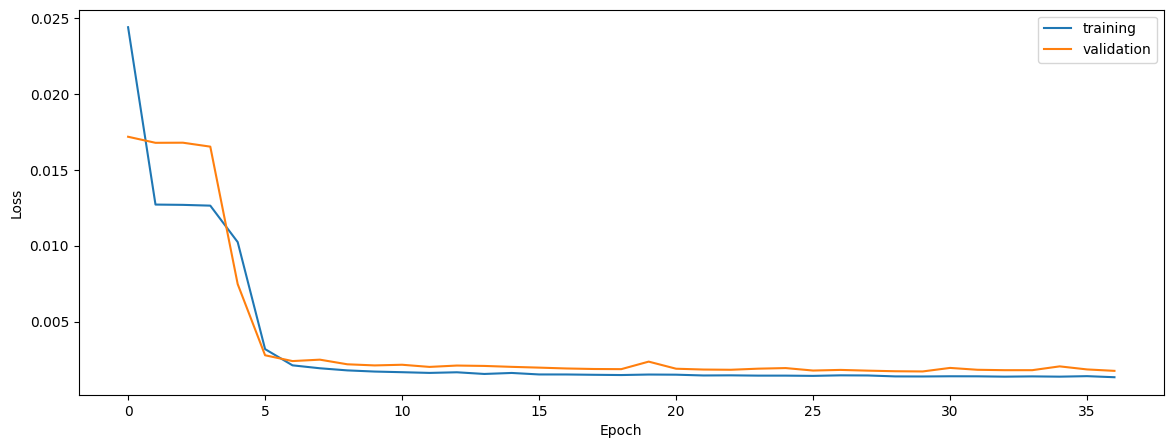

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


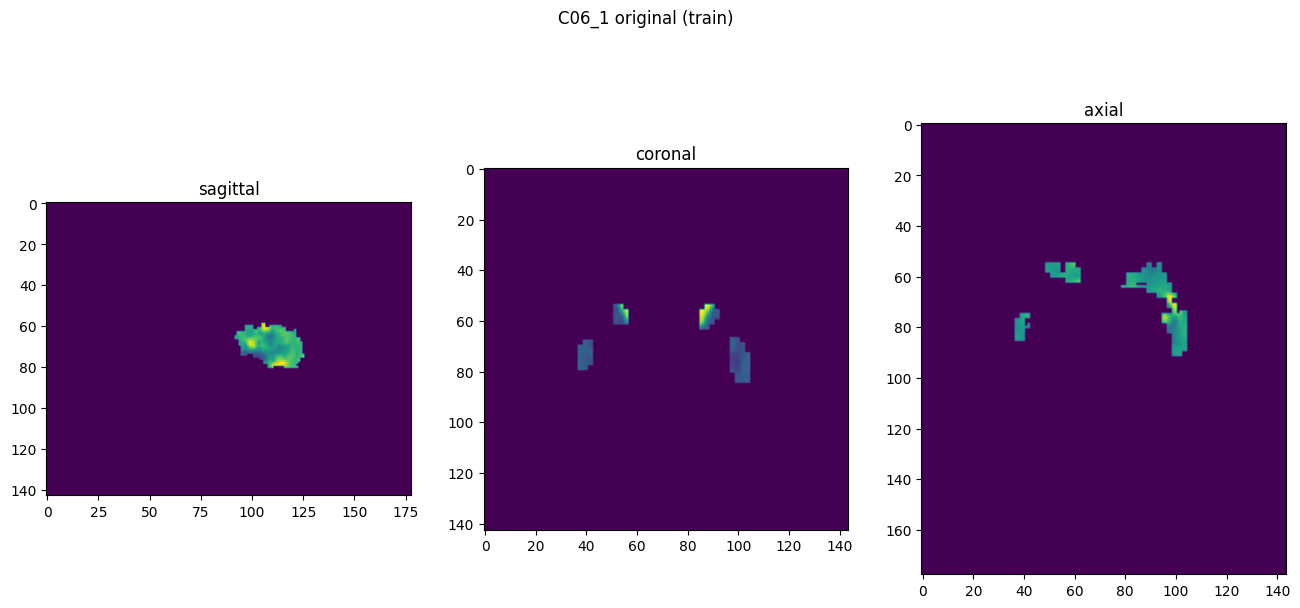

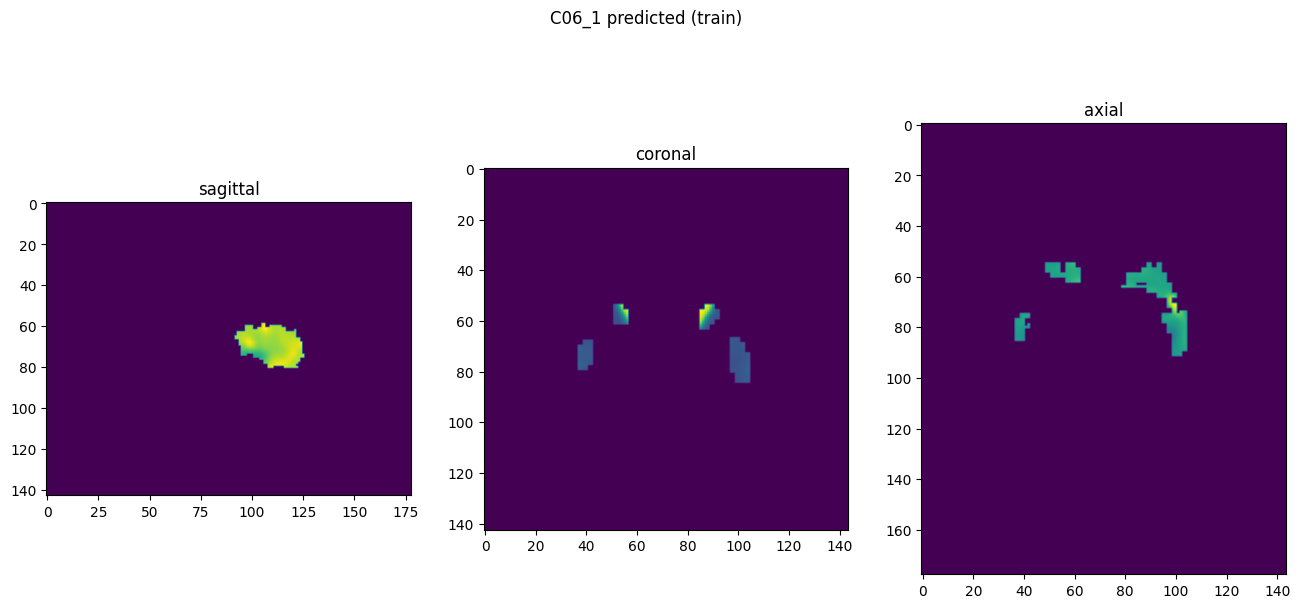

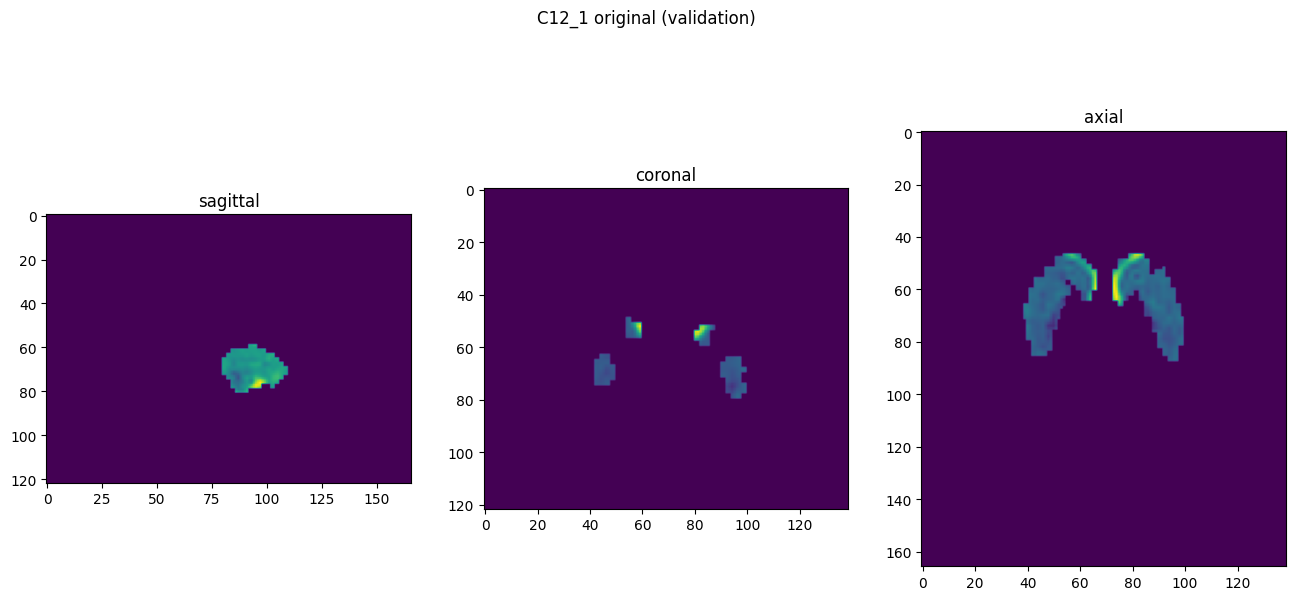

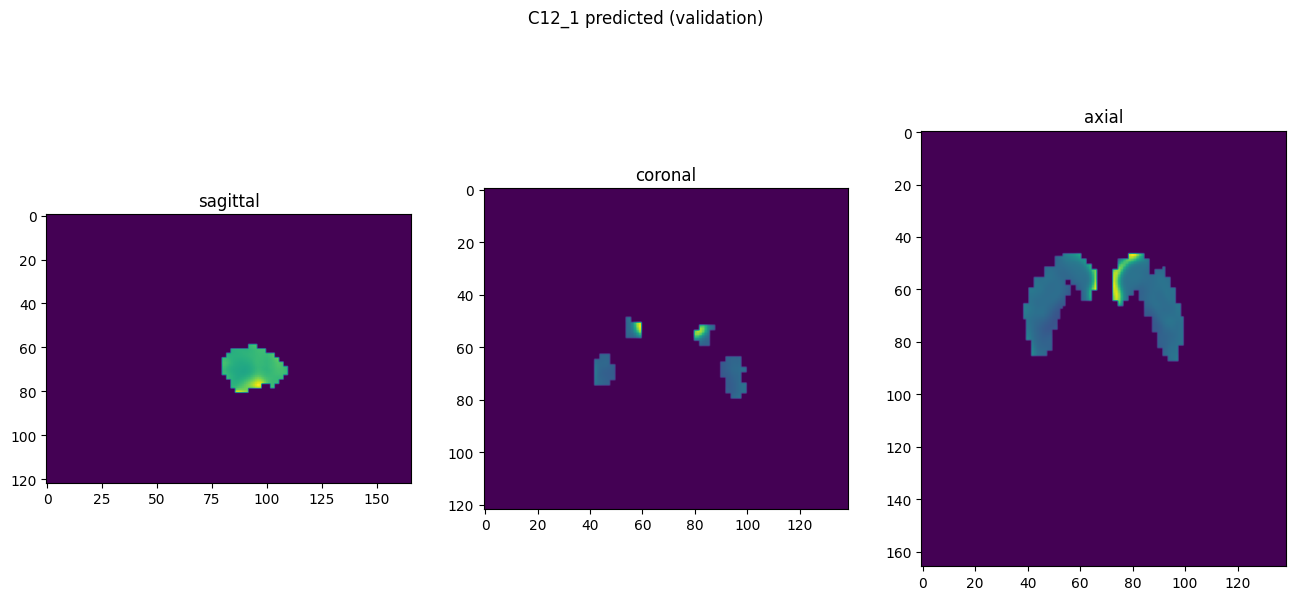

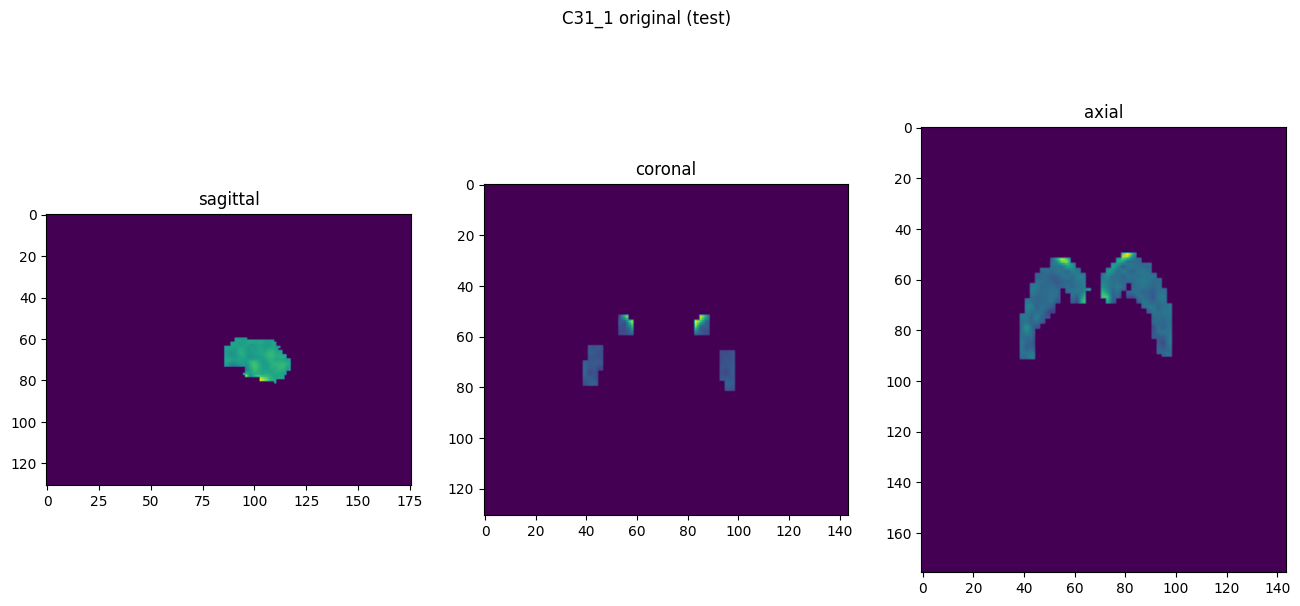

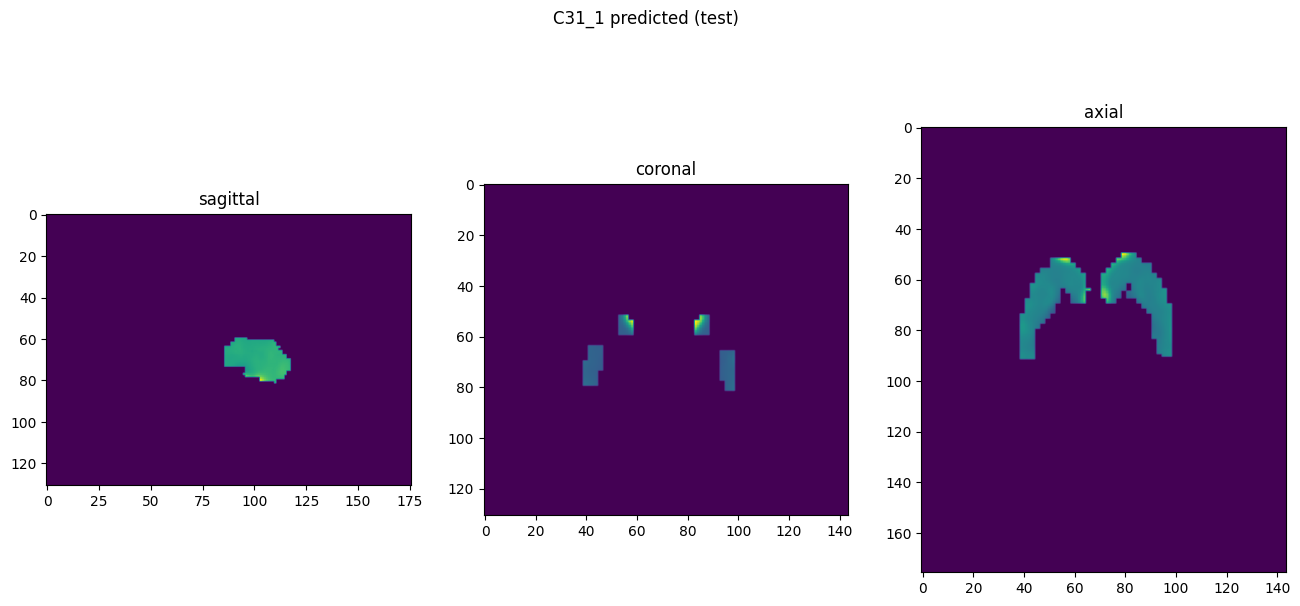

In [10]:
showResults(model, gen, threshold=None, background=False)